# Análise dos dados do Covid-19 (05/04)
Queremos entender a relação entre a letalidade registrada, quantidade de testes disponíveis e outras variáveis relacionadas à manifestação do novo coronavírus no mundo.
Para isso precisaremos de uma fonte de dados confiável. Podemos tentar usar o Worldometer, mas não possui API disponível. Temos um Dataset de casos nos EUA (https://github.com/nytimes/covid-19-data.git). Vamos começar por ele.

#### Importando as bibliotecas utilizadas e importando o dataset

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd
from scipy import optimize

In [2]:
dataCount = pd.read_csv('covid-19-data/us-counties.csv') 
dataStates = pd.read_csv('covid-19-data/us-states.csv')

#### Vamos vizualizar o formato dos nossos dados
Temos dois datasets, um com informações estatais e outro com informações por condado

In [3]:
dataCount.info()          # Dataset por condado

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35698 entries, 0 to 35697
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    35698 non-null  object 
 1   county  35698 non-null  object 
 2   state   35698 non-null  object 
 3   fips    35180 non-null  float64
 4   cases   35698 non-null  int64  
 5   deaths  35698 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 1.6+ MB


In [4]:
dataStates.info()          # Dataset por estado

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1884 entries, 0 to 1883
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1884 non-null   object
 1   state   1884 non-null   object
 2   fips    1884 non-null   int64 
 3   cases   1884 non-null   int64 
 4   deaths  1884 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 73.7+ KB


Optaremos por trabalhar no dataset sobre estados, por enquanto. Vamos entendê-lo melhor.

In [5]:
dataStates.head(10)

date       state  fips  cases  deaths
0  2020-01-21  Washington    53      1       0
1  2020-01-22  Washington    53      1       0
2  2020-01-23  Washington    53      1       0
3  2020-01-24    Illinois    17      1       0
4  2020-01-24  Washington    53      1       0
5  2020-01-25  California     6      1       0
6  2020-01-25    Illinois    17      1       0
7  2020-01-25  Washington    53      1       0
8  2020-01-26     Arizona     4      1       0
9  2020-01-26  California     6      2       0

O estado com o maior número de mortes possui 4161 mortes. Informação que está de acordo com os dados oficiais de Nova Yorke para o dia 04/04

In [6]:
max(dataStates.deaths)

4161

Como sabemos que todos os casos ocorreram em 2020, podemos retirar essa informação

In [7]:
newdate = []
for date in dataStates.date:
    d = date.replace('2020-','')
    newdate.append(d)
dataStates.date = newdate

Temos informação de 55 regiões. Isso é mais do que os proprios 50 estados dos EUA, pois inclui alguns territórios como Porto Rico

In [8]:
print(dataStates.state.nunique())
states = dataStates.state.unique()
states

55


array(['Washington', 'Illinois', 'California', 'Arizona', 'Massachusetts',
       'Wisconsin', 'Texas', 'Nebraska', 'Utah', 'Oregon', 'Florida',
       'New York', 'Rhode Island', 'Georgia', 'New Hampshire',
       'North Carolina', 'New Jersey', 'Colorado', 'Maryland', 'Nevada',
       'Tennessee', 'Hawaii', 'Indiana', 'Kentucky', 'Minnesota',
       'Oklahoma', 'Pennsylvania', 'South Carolina',
       'District of Columbia', 'Kansas', 'Missouri', 'Vermont',
       'Virginia', 'Connecticut', 'Iowa', 'Louisiana', 'Ohio', 'Michigan',
       'South Dakota', 'Arkansas', 'Delaware', 'Mississippi',
       'New Mexico', 'North Dakota', 'Wyoming', 'Alaska', 'Maine',
       'Alabama', 'Idaho', 'Montana', 'Puerto Rico', 'Virgin Islands',
       'Guam', 'West Virginia', 'Northern Mariana Islands'], dtype=object)

Temos dados de 21/01 até 05/04, totalizando 76 dias.

In [9]:
print(dataStates.date.nunique())
dates = dataStates.date.unique()
dates

76


array(['01-21', '01-22', '01-23', '01-24', '01-25', '01-26', '01-27',
       '01-28', '01-29', '01-30', '01-31', '02-01', '02-02', '02-03',
       '02-04', '02-05', '02-06', '02-07', '02-08', '02-09', '02-10',
       '02-11', '02-12', '02-13', '02-14', '02-15', '02-16', '02-17',
       '02-18', '02-19', '02-20', '02-21', '02-22', '02-23', '02-24',
       '02-25', '02-26', '02-27', '02-28', '02-29', '03-01', '03-02',
       '03-03', '03-04', '03-05', '03-06', '03-07', '03-08', '03-09',
       '03-10', '03-11', '03-12', '03-13', '03-14', '03-15', '03-16',
       '03-17', '03-18', '03-19', '03-20', '03-21', '03-22', '03-23',
       '03-24', '03-25', '03-26', '03-27', '03-28', '03-29', '03-30',
       '03-31', '04-01', '04-02', '04-03', '04-04', '04-05'], dtype=object)

## Analises
Agora que ja entendemos melhor os nossos dados, podemos passar para algumas análises. A partir do número de casos diários, podemos calcular o seu gradiente, ou seja, quantos casos diários tivemos por estado

In [10]:
gradients = []
for state in states:
    gradient = []
    stateData = dataStates.loc[dataStates['state'] == state]
    pastCase = 0
    for index, row in stateData.iterrows():
        gradient.append(row.cases - pastCase)
        pastCase = row.cases
    gradients.append(gradient)

Podemos fazer o mesmo para o gradiente para podermos encontrar algo que se assemelhe à 'aceleração' da epidemia por estado

In [11]:
acel = []
for state in gradients:
    s = []
    pastgrad  = 0
    for grad in state:
        s.append(grad - pastgrad)
        pastgrad = grad
    acel.append(s)

## EUA em geral
Vamos dar uma olhada no que os dados nos dizem sobre a situação dos Estados Unidos. Então, criaremos um dataframe para a situação geral do país

In [18]:
USdata = pd.DataFrame(columns=['date','cases','deaths'])
for date in dates:
    dateData = dataStates.loc[dataStates['date'] == date]
    USdata = USdata.append({'date':date, 'cases':sum(dateData.cases), 'deaths':sum(dateData.deaths)}, ignore_index=True)
USdata.head()

date cases deaths
0  01-21     1      0
1  01-22     1      0
2  01-23     1      0
3  01-24     2      0
4  01-25     3      0

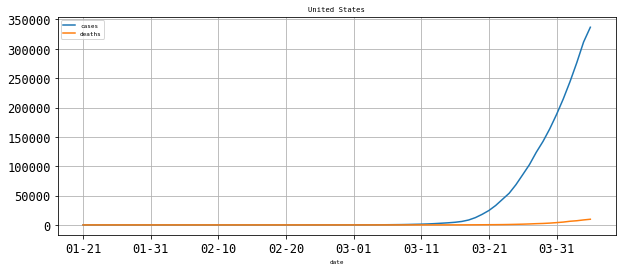

In [63]:
USdata.plot(x='date', figsize=(10,4), title = 'United States', grid=True, fontsize=12)

### Regressão Exponencial
Vamos tentar encaixar os dados empíricos em uma curva exponencial.

In [109]:
x = np.zeros(len(USdata))
y = np.zeros(len(USdata))

for i in USdata.index:
    x[i] = i
    y[i] = USdata.cases[i]

In [114]:
expFit1 = np.polyfit(x, np.log(y), 1)
expFit2 = np.polyfit(x, np.log(y), 1, w=np.sqrt(y))
scipyFit = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y,  p0=(4, 0.1))
scipyFit[0]

array([4.88787709, 0.14961846])

In [115]:
x = USdata.index
y1 = np.exp(expFit1[0]*x) * np.exp(expFit1[1])
y2 = np.exp(expFit2[0]*x) * np.exp(expFit2[1])
y3 = scipyFit[0][0] * np.exp(scipyFit[0][1] * x)

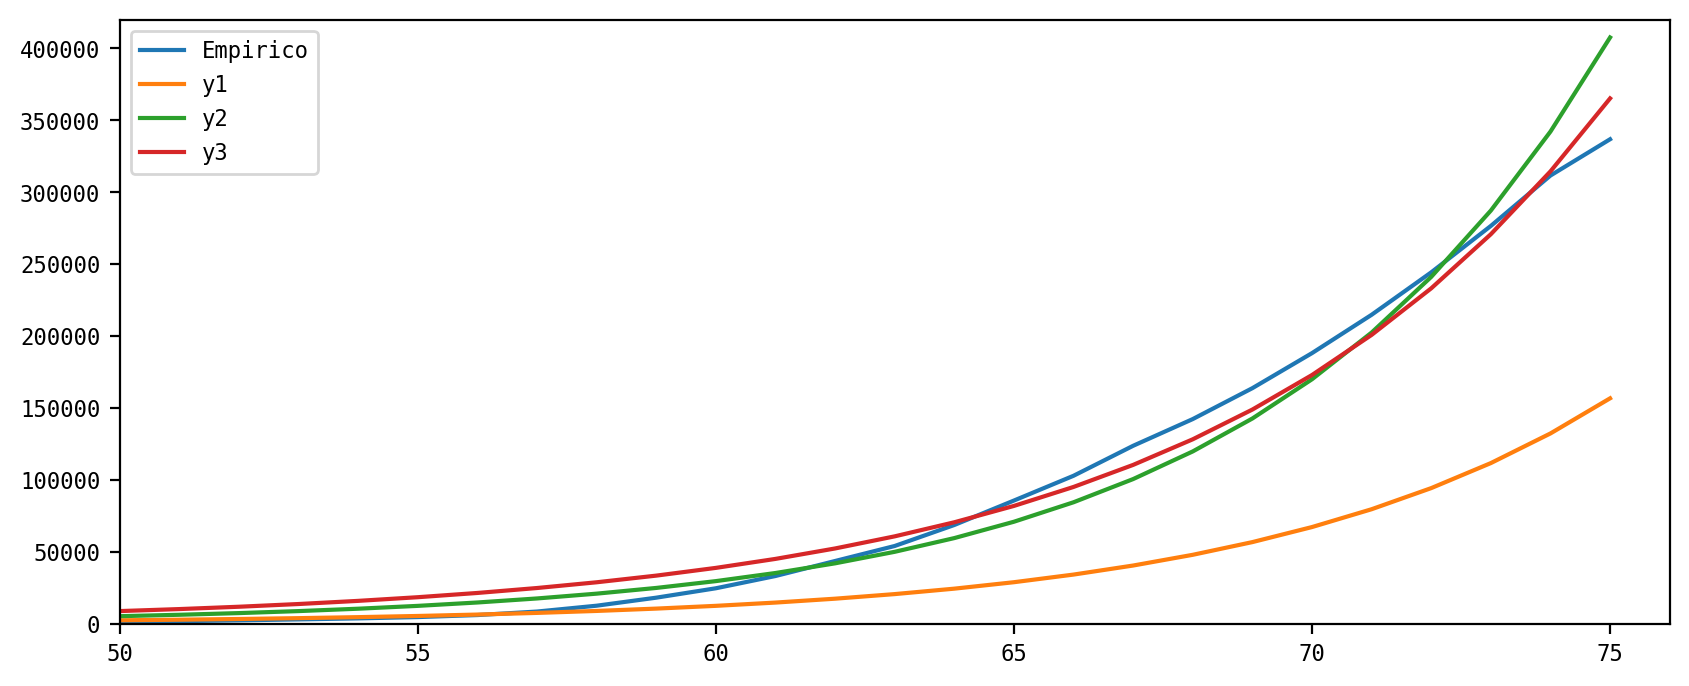

In [150]:
plt.figure(num = None, figsize=(10,4), dpi=200, facecolor='w', edgecolor='k')
font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 8}
plt.rc('font', **font)  # pass in the font dict as kwargs

plt.plot(USdata.cases, label="Empirico")
plt.plot(x, y1, label = 'y1')
plt.plot(x, y2, label = 'y2')
plt.plot(x, y3, label = 'y3')
plt.axis([50, 76, 0, 420000])
plt.legend()

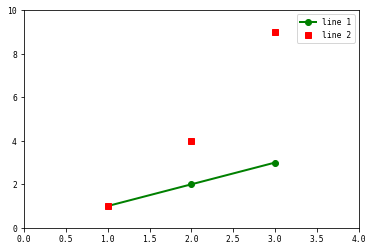

In [143]:
plt.plot([1,2,3], [1,2,3], 'go-', label='line 1', linewidth=2)
plt.plot([1,2,3], [1,4,9], 'rs',  label='line 2')
plt.axis([0, 4, 0, 10])
plt.legend()

#### Nova Yorke
Por ser o maior centro da epidemia no país, vamos verificar primeiro o comportamento da doença no estado de NY.

O primeiro caso da doença na cidade foi registrado no dia 01/03

In [12]:
nyData = dataStates.loc[dataStates['state'] == 'New York']
nyData.date[246]

'03-01'

In [148]:
plt.figure(num = None, figsize=(10,16), dpi=1200, facecolor='w', edgecolor='k')
font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 6}
plt.rc('font', **font)  # pass in the font dict as kwargs

plt.subplot(411)
plt.plot_date('date', 'cases','b', data=nyData)
plt.title('Total cases')
plt.grid(True)

plt.subplot(412)
plt.plot('date', 'cases','bo--', data=nyData)
plt.yscale('log')
plt.title('Total cases log scale')
plt.grid(True)

plt.subplot(413)
ny = np.where(states == 'New York')[0][0]
plt.bar(nyData.date, gradients[ny])
plt.title('Daily new cases')
plt.grid(True)

plt.subplot(414)
plt.plot(nyData.date, acel[ny],  'bo--')
plt.plot(np.zeros(len(nyData.date)), 'r')
plt.title('Daily acceleration')
plt.grid(True)

plt.suptitle('New York')
plt.show()

### California

In [39]:
caData = dataStates.loc[dataStates['state'] == 'California']
caData.date[5]

'01-25'

In [60]:
plt.figure(num = None, figsize=(10,16), dpi=1200, facecolor='w', edgecolor='k')
font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 6}
plt.rc('font', **font)  # pass in the font dict as kwargs

plt.subplot(411)
plt.plot('date', 'cases','b', data=caData)
plt.title('Total cases')
plt.grid(True)

plt.subplot(412)
plt.plot('date', 'cases','bo--', data=caData)
plt.yscale('log')
plt.title('Total cases log scale')
plt.grid(True)

plt.subplot(413)
ca = np.where(states == 'California')[0][0]
plt.bar(caData.date, gradients[ca])
plt.title('Daily new cases')
plt.grid(True)

plt.subplot(414)
plt.plot(caData.date, acel[ca],  'bo--')
plt.plot(np.zeros(len(caData.date)), 'r')
plt.title('Daily acceleration')
plt.grid(True)

plt.suptitle('California')
plt.show()

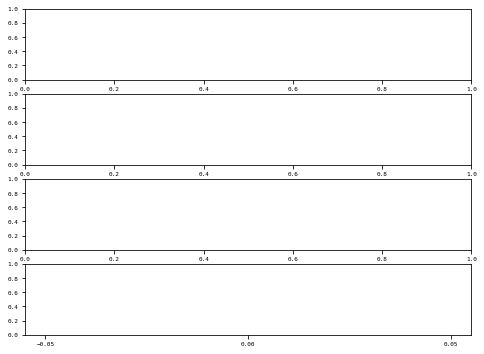

In [57]:
fig, axs = plt.subplots(4, 1, figsize=(8, 6))
plt.locator_params(axis='x', nbins=1)